# <span style="color:#0b486b">  FIT3181: Deep Learning (2021)</span>
***
*CE/Lecturer:*  **Dr Trung Le** | trunglm@monash.edu <br/>
*Head TA:*  **Mr Thanh Nguyen** | thanh.nguyen4@monash.edu <br/>
*Tutor:* **Dr Van Nguyen**  \[van.nguyen1@monash.edu \] | **Mr James Tong** \[james.tong1@monash.edu\] | **Dr Mahmoud Mohammad** \[mahmoud.hossam@monash.edu\]
<br/> <br/>
Faculty of Information Technology, Monash University, Australia
***


# <span style="color:#0b486b">Tutorial 7d: Transfer Learning and Fine Tuning</span> <span style="color:red">***</span> #
This is an **encourage-to-learn** knowledge since transfer learning is an important practical skill to train DL models when we possess a tiny dataset.

**For real-world projects, in many cases, we possess a tiny dataset for building up DL models. In those situations, transfer learning is an efficient and practical workaround in which we take advantage of a pretrained SOTA model trained on large-scale datasets for example ImageNet and transfer the learning to target the tiny dataset. This tutorial will present you with how to perform transfer learning from a SOTA CNN model and do fine-tuning to target another tiny dataset.**


**References and additional reading and resources**
- Tensorflow dataset ([link](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)).
- A comprehensive hands-on guide to an introduction to transfer learning ([link](https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a)).

---


## <span style="color:#0b486b">I. Introduction of Transfer Learning</span> ##

Transfer learning (a.k.a domain adaptation) is an active and exalted research direction in machine learning and deep learning due to its practical applications. In this tutorial, we only consider a simple scenario of transfer learning in which we transfer the learning from a pretrained CNN model trained on ImageNet dataset to construct another model that is expected to work well on a tiny dataset of thousands of images. Certainly, this tiny dataset alone cannot assist us in training a good DL model due to its restrictive training examples.

The pipeline for transfer learning is as follows:
- We first load a pretrained CNN model and use the part of this network from the input to the last tensor before the flattened layer as a feature extractor.
- On the top of the feature extractor, we build up some dense layers known as a classifier to target the tiny training set.
- We then train the classifier and keep fixed the feature extractor so that the classifier has a chance to warm up and learn patterns of the tiny dataset.
- We finally allow to update both feature extractor and classifier but only using small learning rates.

In this tutorial, we transfer the learning of the pretrained CNN model `VGG19` trained on ImageNet to target the flower dataset with approximately $3000$ training images.

## <span style="color:#0b486b">II. Download and process the flower dataset</span> ##

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
%matplotlib inline

We download the flower dataset to our hard disk.

In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)
# print(data_dir)

There are 3670 images of five classes (i.e., 'daisy', 'dandelion', 'roses', 'sunflowers', and 'tulips') of flowers in this dataset.

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


We show some images on this dataset.

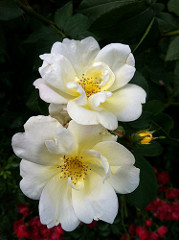

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

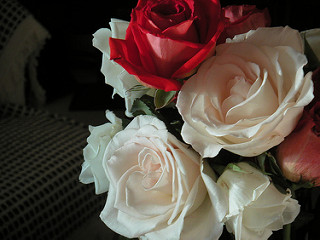

In [6]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

In [7]:
batch_size = 32
img_height = 224
img_width = 224

We create a list of all file names of images in the dataset folder.

In [8]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [9]:
for f in list_ds.take(5):
    print(f.numpy())

b'C:\\Users\\vngu0061\\.keras\\datasets\\flower_photos\\sunflowers\\6250692311_cb60c85ee9_n.jpg'
b'C:\\Users\\vngu0061\\.keras\\datasets\\flower_photos\\roses\\8462246855_1bdfee7478.jpg'
b'C:\\Users\\vngu0061\\.keras\\datasets\\flower_photos\\tulips\\16711791713_e54bc9c1af_n.jpg'
b'C:\\Users\\vngu0061\\.keras\\datasets\\flower_photos\\dandelion\\2257649769_deaf97e2c9_n.jpg'
b'C:\\Users\\vngu0061\\.keras\\datasets\\flower_photos\\tulips\\3516269489_cef36e87a6.jpg'


We create a list of all class names, each of which corresponds to a folder in the dataset folder.

In [10]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


We split $80\%$ for training and the rest $20\%$ for validating.

In [11]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [12]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


The function `process_path` allows us to process a specific image file which includes two steps: get label (`def def get_label(file_path)`), and read file and store image file in the memory as jpeg format (`def decode_img(img)`).

In [13]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    one_hot =  tf.cast(parts[-2] == class_names, tf.float32)
    # Integer encode the label
    return tf.argmax(one_hot)

In [14]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [15]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [16]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path)
val_ds = val_ds.map(process_path)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [17]:
for image, label in train_ds.take(2):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  1
Image shape:  (224, 224, 3)
Label:  3


We now have two Tensorflow datasets: `train_ds` and `val_ds`. For more information on TF dataset, you can refer to the [link](https://www.tensorflow.org/api_docs/python/tf/data/Dataset). In what follows, we create two TF batch datasets with the $batch\_size= 32$ by default.

In [18]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)   # shuffle the dataset
    ds = ds.batch(batch_size)    # partition the dataset to obtain a batch dataset
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)  # prefetch some batches for faster processing
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

We now plot some flower images in the training set.

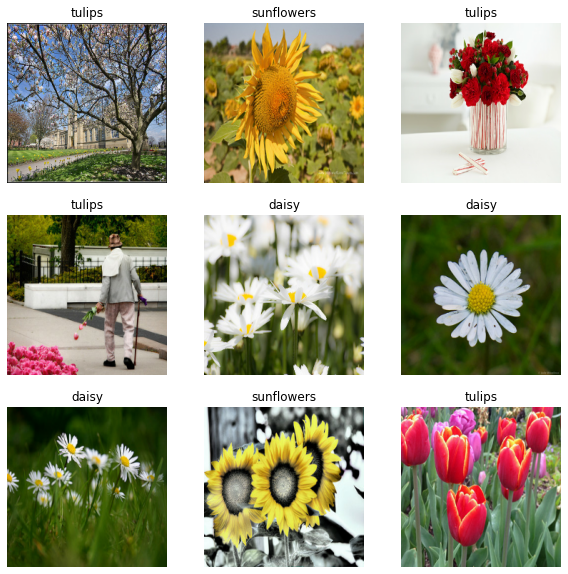

In [19]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

## <span style="color:#0b486b">III. Transfer learning with pretrained model</span> ##

We load the pretrained CNN model `VGG19`.

In [20]:
from tensorflow.keras.applications import VGG19

In [22]:
print("Loading network...")
base_model = VGG19(weights="imagenet", include_top=False, input_tensor=tf.keras.layers.Input(shape=(224,224,3)))
print("Showing layers...")
# loop over the layers in the network and display them to the console
for (i, layer) in enumerate(base_model.layers):
    print("{}\t{}".format(i, layer.__class__.__name__))

Loading network...
Showing layers...
0	InputLayer
1	Conv2D
2	Conv2D
3	MaxPooling2D
4	Conv2D
5	Conv2D
6	MaxPooling2D
7	Conv2D
8	Conv2D
9	Conv2D
10	Conv2D
11	MaxPooling2D
12	Conv2D
13	Conv2D
14	Conv2D
15	Conv2D
16	MaxPooling2D
17	Conv2D
18	Conv2D
19	Conv2D
20	Conv2D
21	MaxPooling2D


We build upon the top of the pretrained model (feature extractor part) two dense layers as follows. Note that we currently set `base_model.trainable= False` to allow only the new classifier on the top of the base model to be updated.

In [23]:
class FCHeadNet:
    @staticmethod
    def build(base_model, n_classes=5, D=100): # initialize the head model that will be placed on top of he base, then add a FC layer
        base_model.trainable= False
        head_model = base_model.output
        head_model = tf.keras.layers.Flatten(name="flatten")(head_model)
        head_model = tf.keras.layers.Dense(D, activation="relu")(head_model)
        head_model = tf.keras.layers.Dropout(0.3)(head_model)
        # add a softmax layer
        head_model = tf.keras.layers.Dense(n_classes, activation="softmax")(head_model)
        return head_model

We initialize a model to learn from the flower dataset.

In [24]:
head_model = FCHeadNet.build(base_model, 5, 256)
model = tf.keras.models.Model(inputs=base_model.input, outputs=head_model)

In [25]:
opt = tf.keras.optimizers.RMSprop(lr=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

We train the new model on the flower dataset. Note that at the moment, we only update the classifier on the top. Owning the existed patterns of `VGG19`, we can obtain a good performance.

In [26]:
model.fit(train_ds, epochs=5, validation_data=val_ds)

Epoch 1/5
92/92 [==============================] - 384s 4s/step - loss: 9.2897 - accuracy: 0.6543 - val_loss: 1.2283 - val_accuracy: 0.7193
Epoch 2/5
92/92 [==============================] - 404s 4s/step - loss: 1.1756 - accuracy: 0.7888 - val_loss: 1.0466 - val_accuracy: 0.7766
Epoch 3/5
92/92 [==============================] - 395s 4s/step - loss: 0.6805 - accuracy: 0.8559 - val_loss: 0.9966 - val_accuracy: 0.8025
Epoch 4/5
92/92 [==============================] - 399s 4s/step - loss: 0.5582 - accuracy: 0.8992 - val_loss: 1.4006 - val_accuracy: 0.8079
Epoch 5/5
92/92 [==============================] - 396s 4s/step - loss: 0.5476 - accuracy: 0.9091 - val_loss: 1.4616 - val_accuracy: 0.7970


We now train both the feature extractor and classifier with a small learning rate.

In [43]:
base_model.trainable = True
model.fit(train_ds, epochs=2, validation_data=val_ds)

Train for 92 steps, validate for 23 steps
Epoch 1/2
92/92 [==============================] - 605s 7s/step - loss: 0.6188 - accuracy: 0.9305 - val_loss: 2.5430 - val_accuracy: 0.8202
Epoch 2/2
92/92 [==============================] - 598s 7s/step - loss: 0.5827 - accuracy: 0.9401 - val_loss: 2.3860 - val_accuracy: 0.8556


**<span style="color:red">Exercise 1</span>**: Use another pretrained model for example `ResNet50` for transfer learning and report your result. You might consider to run your code on Google Colab due to the complexity of `ResNet50`.


---
### <span style="color:#0b486b"> <div  style="text-align:center">**THE END**</div> </span>